# Intro to satellite data  III -- regridding continued

In this notebook we use the functions developed in satellite_II to regrid the image

1) regrid the image binned on latitude and longitude and do a
   raw image plot using imshow
   
2) turn the image into a numpy masked array, with the mask covering all those lat/lon bins with no data, and plot using pcolormesh
   

In [1]:
from e582utils.data_read import download
import numpy as np
import h5py
import sys
filename = 'MYD021KM.A2016136.2015.006.2016138123353.h5'
download(filename)

MYD021KM.A2016136.2015.006.2016138123353.h5 already exists, need to either delete or rename for new download


Here is the corresponding red,green,blue color composite for the granule.

In [2]:
from IPython.display import Image
Image(url='http://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/aqua_136_2015.jpg',width=600)

In [3]:
h5_file=h5py.File(filename)

### **Read the radiance data from MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive**

According to the [Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php)
channel 31 is centered at 11 microns.  The Band_1KM_Emissive band listing says that this is index 10 of the the Emissive data array.  Note that Channel 26 is missing:

In [4]:
index31=10

my_name = 'EV_1KM_Emissive'
chan31=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name][index31,:,:]
scale=h5_file['MODIS_SWATH_Type_L1B']['Data Fields']['EV_1KM_Emissive'].attrs['radiance_scales'][...]
offset=h5_file['MODIS_SWATH_Type_L1B']['Data Fields']['EV_1KM_Emissive'].attrs['radiance_offsets'][...]
chan31_calibrated =(chan31 - offset[index31])*scale[index31]

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

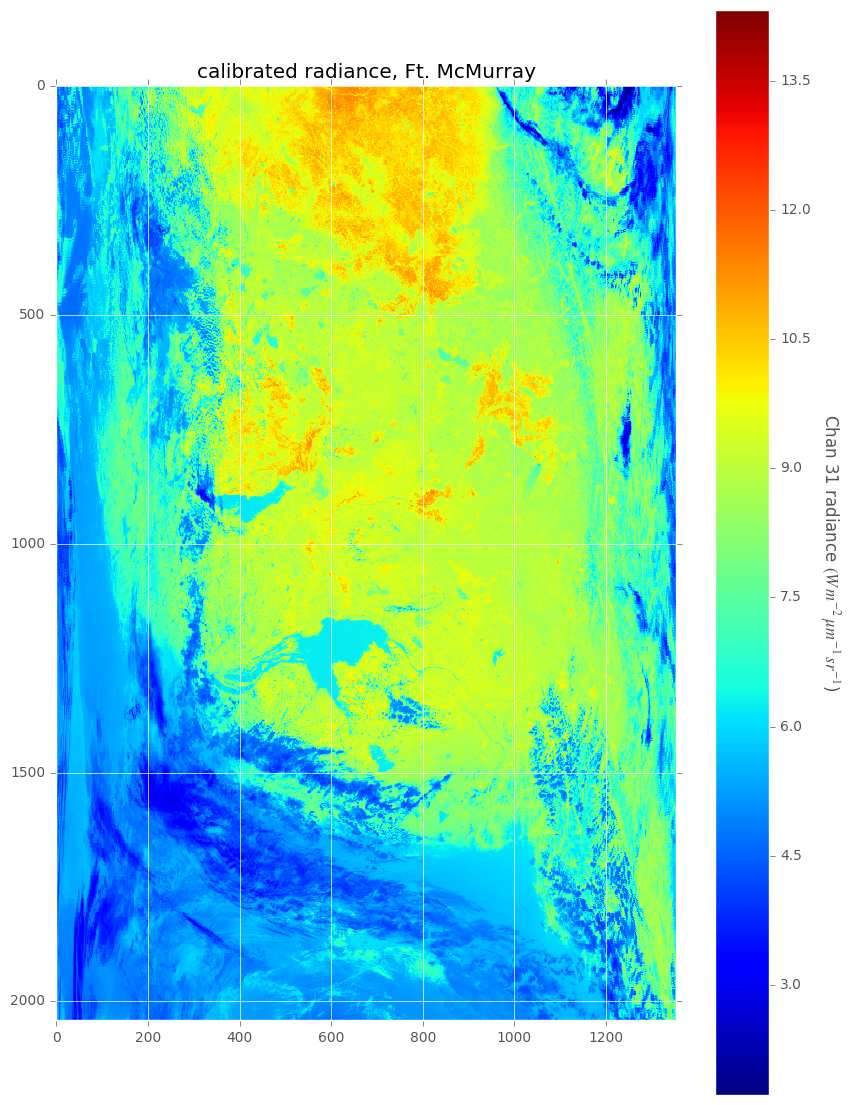

In [6]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(chan31_calibrated)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')


In [7]:
filename='MYD03.A2016136.2015.006.2016138121537.h5'
download(filename)
geo_file = h5py.File(filename)
lon_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][...]
lat_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][...]

MYD03.A2016136.2015.006.2016138121537.h5 already exists, need to either delete or rename for new download


### use the lat/lon of each pixel to place it in a bin -- the binned lats and lons form the image grid

start with writing a general routine to bin data into evenly spaced bins

In [8]:
def do_hist(data_vec,numbins,minval,maxval):
    """
    bin data_vec into numbins evenly spaced bins from left edge
    minval to right edge maxval
    
    Parameters
    ----------
    
    data_vec: numpy vector (float)
       data/pixels to be binned -- 1-d
       
    numbins:  int
       number of histogram bins
    minval:  float
        left edge
    maxval: float
        right edge
        
    Returns
    -------
      dictionary with keys:
      
      index_vec: ndarray 1-d float
        same size as data_vec, with entries containing bin number
        if data is smaller than left edge, missing value is -999
        if data is larger than right edge, missing value is -888
        
      count_vec: ndarray 1-d  int
        size numbins, with number of counts in each bin
      
      edges_vec: ndarray 1-d float
        size numbins+1 containing bin edges
    
      lowcount: int
         number of pixels smaller than left edge
      
      high count: 
         number of pixels larger than right edge
    """
    binsize= (maxval - minval)/numbins
    bin_count = np.zeros([numbins,],dtype=np.int)
    bin_index = np.zeros(data_vec.shape,dtype = np.int)
    bin_index[:] = -1
    lowcount=0
    highcount=0 
   
    for i in range(len(data_vec)):
        float_bin =  ((data_vec[i] - minval) /binsize)
        if float_bin < 0:
            lowcount+=1
            bin_index[i]= -999.
            continue
        if float_bin >= numbins:
            highcount += 1
            bin_index[i] = -888.
            continue
        int_bin = int(float_bin)
        bin_count[int_bin]+=1
        bin_index[i]=int_bin
    bin_edges=[minval + (i*binsize) for i in range(numbins+1)]
    bin_edges = np.array(bin_edges)
    out = dict(index_vec=bin_index,count_vec=bin_count,edges_vec=bin_edges,
             lowcount=lowcount,highcount=highcount)
    
    return out
#

In [9]:
test_rows=150
test_cols=200
row_slice = slice(0,test_rows)  # 0:test_rows
col_slice = slice(0,test_cols)  # 0:test_cols
lon_flat = lon_data[row_slice,col_slice].ravel()[:]
lat_flat = lat_data[row_slice,col_slice].ravel()[:]

lon_min= -103
lon_max = -93
num_lon_bins=100

lon_hist=do_hist(lon_flat,num_lon_bins,lon_min,lon_max)
lat_min = 52
lat_max = 54
num_lat_bins=20
#
# now run the function
#
lat_hist=do_hist(lat_flat,num_lat_bins,lat_min,lat_max)
print(list(lon_hist.keys()))

['count_vec', 'lowcount', 'highcount', 'edges_vec', 'index_vec']


### now take the result of running do_hist the lats and lons and return a 2-dimensional histogram

In [10]:
def find_bins(lon_hist,lat_hist,lon_index,lat_index):
    """
    identify all pixels that have lons in bin lon_index
    and lats in bin lat_index
    
    Parameters
    ----------
    
    lon_hist:  dictionary
        dict returned from do_hist
        
    lat_hist: dictionary
        dict returned from do_hist
        
    lon_index = index of the longitude bin to retrieve
    lat_index = index of the latitude bin to retrieve
    
    Returns
    -------
    
    pixel_list: list
        indices of pixels with lon/lats in the specified lon/lat histogram bin
    """
    keep_lat=[]
    keep_lon=[]
   
    for count,the_index in enumerate(lat_hist['index_vec']):
        if the_index == lat_index:
            keep_lat.append(count)
    for count,the_index in enumerate(lon_hist['index_vec']):
        if the_index == lon_index:
            keep_lon.append(count)
    pixel_list=np.intersect1d(keep_lat,keep_lon)
    return pixel_list

### run find_bins on a portion of our image

In [11]:
chan31_slice=chan31_calibrated[row_slice,col_slice].ravel()
gridded_image=np.full([num_lat_bins,num_lon_bins],np.nan,dtype=np.float32)
for lat_bin in range(num_lat_bins):
    print('lat_bin: ',lat_bin)
    for lon_bin in range(num_lon_bins):
        #
        # find the pixel numbers that belong in this bin
        #
        pixel_list=find_bins(lon_hist,lat_hist,lon_bin,lat_bin)
        if len(pixel_list) > 0:
            #
            # find the mean radiance if there are pixels
            #
            gridded_image[lat_bin,lon_bin] = chan31_slice[pixel_list].mean()

lat_bin:  0
lat_bin:  1
lat_bin:  2
lat_bin:  3
lat_bin:  4
lat_bin:  5
lat_bin:  6
lat_bin:  7
lat_bin:  8
lat_bin:  9
lat_bin:  10
lat_bin:  11
lat_bin:  12
lat_bin:  13
lat_bin:  14
lat_bin:  15
lat_bin:  16
lat_bin:  17
lat_bin:  18
lat_bin:  19


In [12]:
lat_centers=(lat_hist['edges_vec'][1:] + lat_hist['edges_vec'][:-1])/2.
lon_centers=(lon_hist['edges_vec'][1:] + lon_hist['edges_vec'][:-1])/2.

### now display the gridded image using imshow

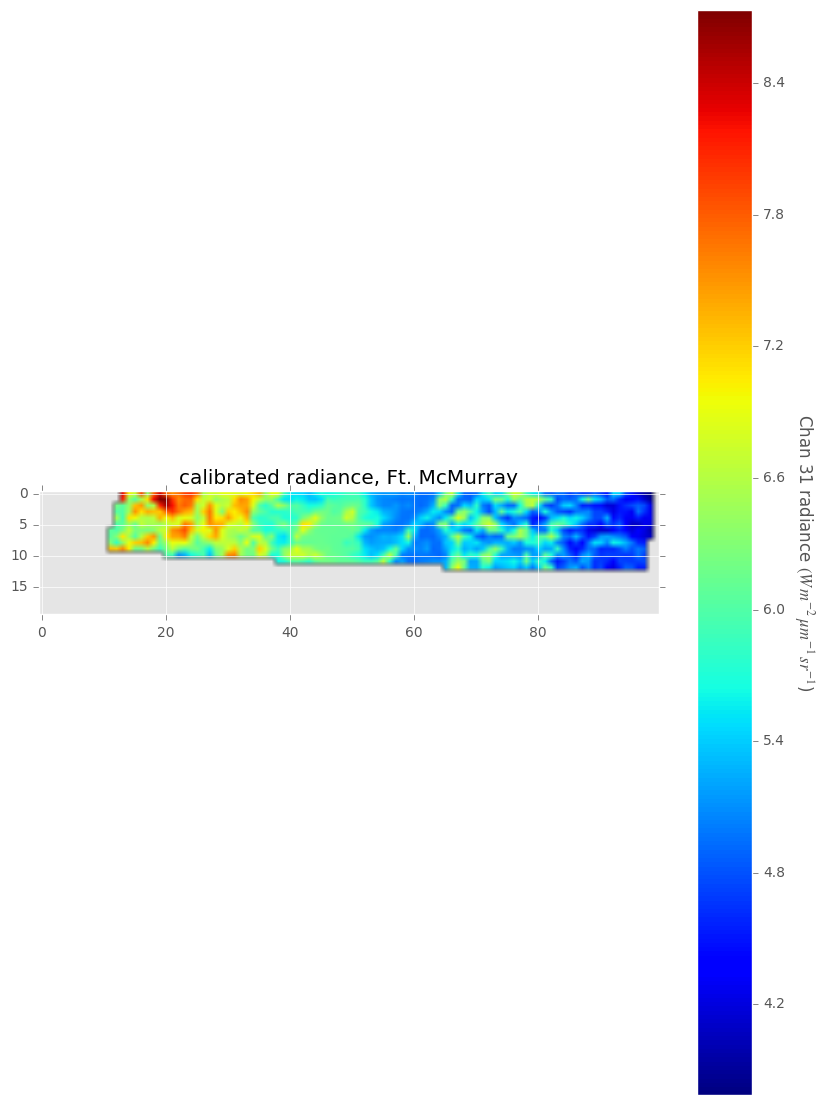

In [13]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(gridded_image)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')

### same image, using pcolor mesh instead of imshow

note that we have writing np.nan values for the grid cells with no data.  imshow knows how to handle
this, but pcolormesh needs to use a [numpy masked array](https://docs.scipy.org/doc/numpy/reference/maskedarray.html)

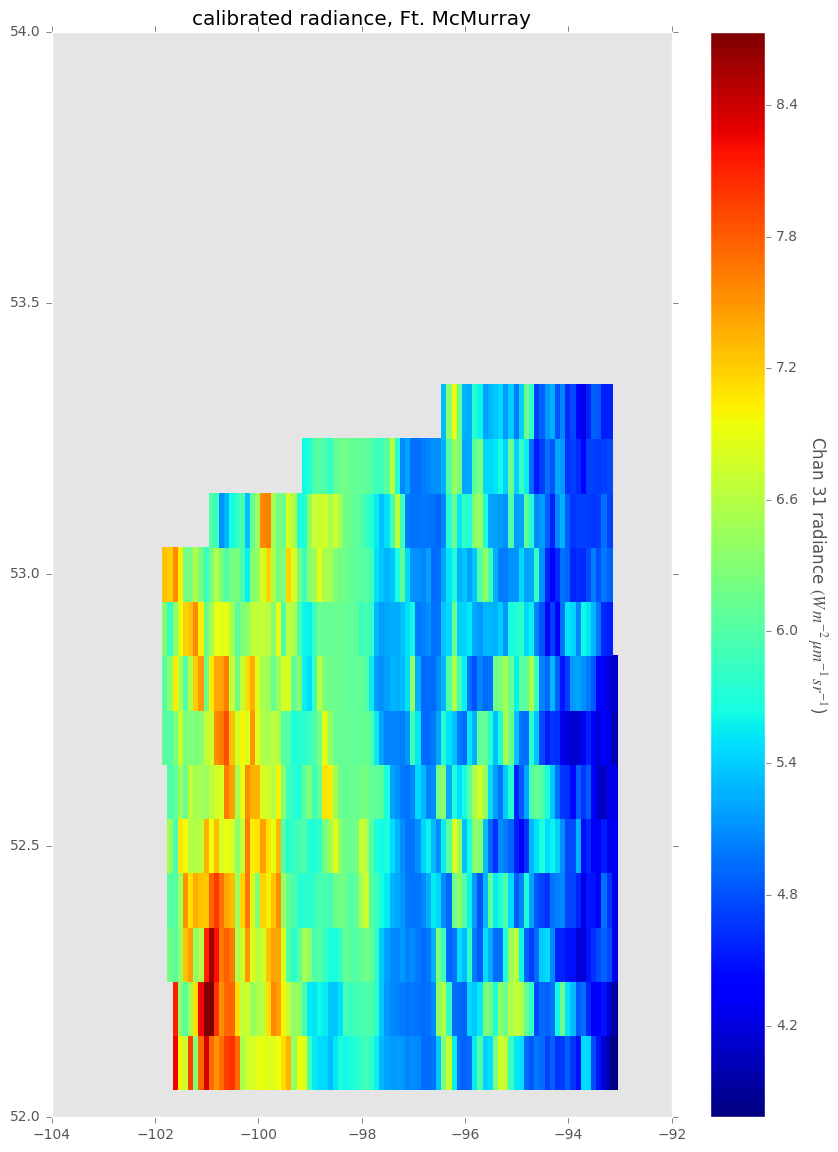

In [14]:
fig,ax = plt.subplots(1,1,figsize = (10,14))
masked_31 = np.ma.masked_invalid(gridded_image)
CS=ax.pcolormesh(lon_centers,lat_centers,masked_31)
cax=fig.colorbar(CS)
ax.set_title('calibrated radiance, Ft. McMurray')
out=cax.ax.set_ylabel('Chan 31 radiance $(W\,m^{-2}\,\mu m^{-1}\,sr^{-1}$)')
out.set_rotation(270)
out.set_verticalalignment('bottom')